In [1]:
import os, code, sys, time
import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L 
import chainer.optimizers as optimizers
import chainer.serializers as serializers
from chainer import cuda
import cupy
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
from data_utils import *
import models, nn, graph_ops

In [2]:
'''
Set array backend, seed
'''
def seed_rng(s):
    xp.random.seed(s)
    np.random.seed(s)
rng_seed = 98765
use_gpu = True
xp = cupy if use_gpu >= 0 else np
print('rng_seed = {}, xp: {}'.format(rng_seed, xp))

rng_seed = 98765, xp: <module 'cupy' from '/home/evan/.pyenv/versions/3.6.3/envs/P363/lib/python3.6/site-packages/cupy/__init__.py'>


In [3]:
'''
Dataset parameters
'''
num_particles = 16 # defaults 16**3
zX, zY = 0.4, 0.0
X,Y = load_data(zX, zY, num_particles)
X, Y = normalize(X), normalize(Y)
print('X.shape: {}, redshifts z{}'.format(X.shape, (zX, zY)))

X.shape: (1000, 4096, 6), redshifts z(0.4, 0.0)


In [4]:
'''
Model, optimizer, and training setup
'''
# Model setup
graph_channels = [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 3] # for graph model
set_channels = [6, 32, 128, 256, 128, 32, 256, 16, 3]

use_graph = False
nn_search_type = ('knn', 14)
channels = graph_channels if use_graph else set_channels
seed_rng(rng_seed)
#model = models.nBodyModel(channels, use_graph=use_graph)
model = models.VelocityBias()
if use_gpu: model.to_gpu() # can specify gpu device with device=*

# Optimizer setup
lr = 0.01
optimizer = optimizers.Adam(alpha=lr)
optimizer.setup(model)

# Training setup
model_dir = './Models/'
interm_model_dir = model_dir + 'interm/'
if not os.path.exists(interm_model_dir): os.makedirs(interm_model_dir)
bound = 0.095
batch_size = 8
n_iters = 1000
loss_history = np.zeros((n_iters), dtype=np.float32)
'''
naming postfix convention:
|dataset|batch_size|iterations|learning_rate|
eg: 16_64_1000_001
'''
#mode_name = 'setmodel_16_8_1000_01_',
model_name = 'velmodel_16_8_1000_01_'

seed_rng(rng_seed)
x_in, x_true = next_minibatch([X,Y], batch_size)

print('Session info: \nrng_seed: {}, ndarray_backend: {}'.format(rng_seed, xp))
print('redshifts: {}, num_particles: {}**3, data.shape: {}'.format((zX,zY), num_particles, X.shape))
print('n_iters: {}, batch_size: {}, lr: {}'.format(n_iters, batch_size, lr))
print('graph_model: {}, channels: {}'.format(use_graph, channels))

Session info: 
rng_seed: 98765, ndarray_backend: <module 'cupy' from '/home/evan/.pyenv/versions/3.6.3/envs/P363/lib/python3.6/site-packages/cupy/__init__.py'>
redshifts: (0.4, 0.0), num_particles: 16**3, data.shape: (1000, 4096, 6)
n_iters: 1000, batch_size: 8, lr: 0.01
graph_model: False, channels: [6, 32, 128, 256, 128, 32, 256, 16, 3]


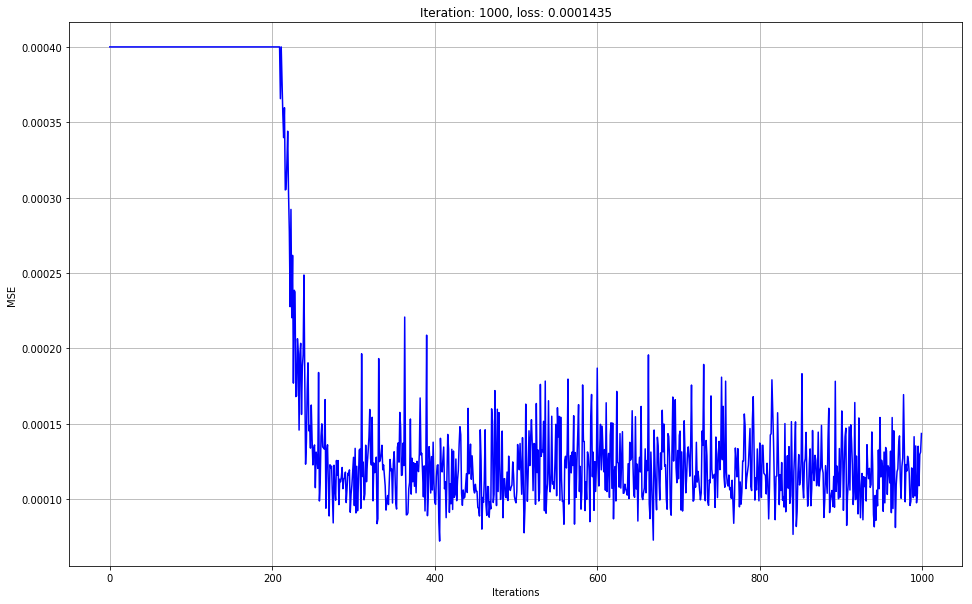

In [5]:
'''
Train loop
'''
for cur_iter in range(1, n_iters + 1):
    model.zerograds()
    idx_iter = cur_iter-1
    save_cond = (cur_iter % 10 == 0)
    # create mini-batches for training
    _x_in, _x_true = next_minibatch([X,Y], batch_size)
    x_in, x_true   = to_variable([_x_in, _x_true])
    
    # get prediction and loss
    graphNN = graph_ops.GraphNN(_x_in, *nn_search_type) if use_graph else None
    #x_hat = model(x_in, graphNN=graphNN, add=True) # prediction
    x_hat = model(x_in)
    loss = nn.get_MSE(x_hat, x_true, boundary=bound) # bound = 0.095
    
    # backprop and update
    loss.backward()
    optimizer.update()
    loss_history[idx_iter] = cuda.to_cpu(loss.data)
    if save_cond:
        np.save(model_dir + 'loss_history', loss_history)
        y = loss_history[:cur_iter]
        plt.close('all')
        fig = plot_training_curve(y, cur_iter)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)
        if cur_iter % 50 == 0: save_model((model, optimizer), interm_model_dir + model_name + str(cur_iter))
save_model((model, optimizer), model_dir + model_name)

In [6]:
'''
save train data
'''
xt = cuda.to_cpu(x_true.data)
xh = cuda.to_cpu(x_hat.data)
save_name = model_dir + model_name + 'train_'
save_data_batches((_x_in, xt, xh), save_name)

data saved


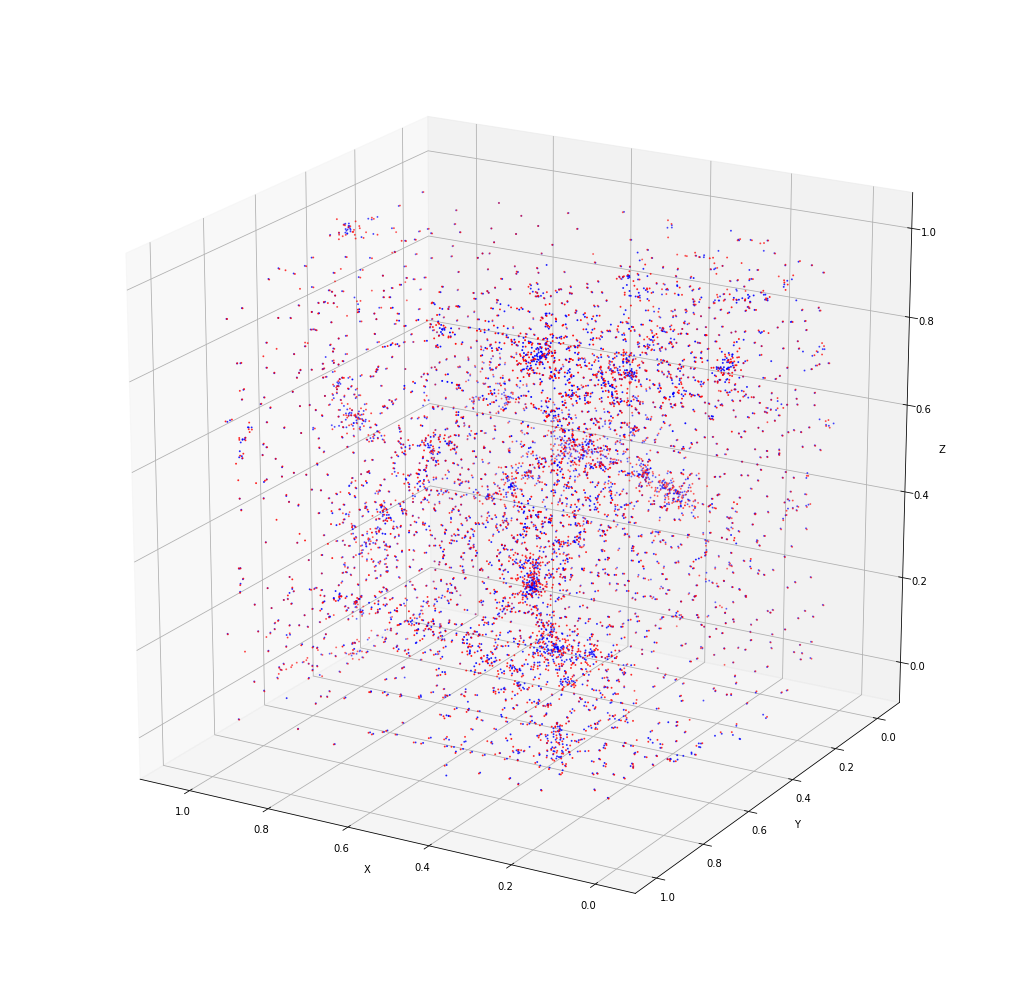

In [12]:
'''
plot point cloud
'''
j = 1
fsize = (18,18)
particle_size = .9
truth_color = 'blue'
pred_color = 'red'
colors = (truth_color, pred_color)

plt.close('all')
fig = plot_3D_pointcloud(xt, xh, j, colors=colors, pt_size=particle_size, fsize=fsize)
plt.gca().view_init(20, 120)
display.display(plt.gcf())
display.clear_output(wait=True)
time.sleep(0.0001)
rotate = False
if rotate:
    for angle in range(0,360,40):
        fig.view_init(30, angle)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)
#fig.savefig('./Plots/' + model_name, dpi=2400,bbox_inches='tight') # warning, this makes a huge image

In [8]:
'''
Save current
'''
print('save {} loss history'.format(model_name))
np.save(model_dir + 'loss_history_' + model_name, loss_history)

save velmodel_16_8_1000_01_ loss history


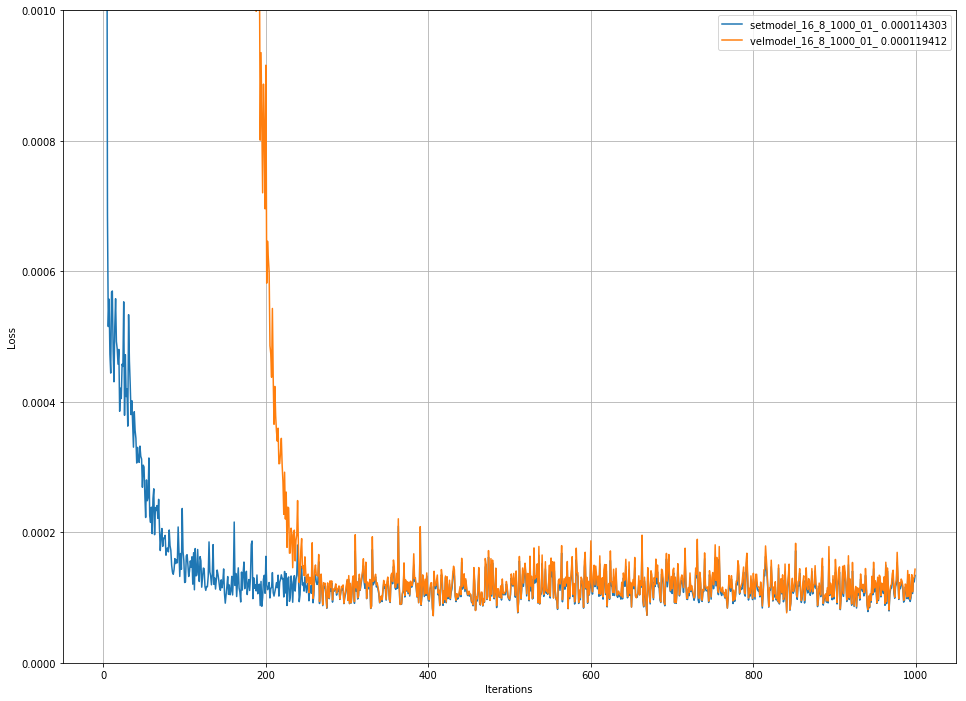

In [10]:
'''
Compare loss curves
'''
loss_labels = ['setmodel_16_8_1000_01_',
               #'graphmodel_14_16_8_1000_01_',
               'velmodel_16_8_1000_01_',
               #'graphmodel_14_16_8_2000_01_',
               #'graphmodel2_14_16_8_2000_01_',
               #'graphmodel2_14_16_8_1000_01_',
              ]
loss_labels32 = ['setmodel_32_8_1000_01_',    
                ]

loss_files = [np.load(model_dir + 'loss_history_' + fname + '.npy') for fname in loss_labels]
loss_curves = {label:loss for label,loss in zip(loss_labels, loss_files)}
iterations = np.arange(loss_files[0].shape[0])
plt.close('all')
plt.clf()
#plt.yscale('log')
plt.figure(figsize=(16,12))
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.ylim([0,.001])
pstart = 0
for label, loss in loss_curves.items():
    #linsp = np.arange(pstart,loss.shape[0])
    #poly = np.poly1d(np.polyfit(linsp, loss[pstart:], 3))
    #plt.plot(iterations[pstart:], poly(iterations[pstart:]), label=(label + ' ' + str(np.mean(loss[-50:]))))
    xvals = np.arange(loss.shape[0])
    plt.plot(xvals[pstart:], loss[pstart:], label=(label + ' ' + str(np.mean(loss[-50:]))))

plt.legend()
plt.show()

In [ ]:
import mayavi
from mayavi import mlab
import numpy as np

"""
Note: this script is in it's own directory because it uses a different
      virtualenv to manage mayavi/vtk dependencies 
"""

def volumize_ptc(data_in, opacity=.5, labels=None, color=(1,0,0),frame=True, 
                 row=0, col=0, show=True, figure=None, proj=(False,True,True),
                 shadow=(False,True,True), mode='point', scale_factor=.015,
                 filename=None,):
    if figure is None:
        figure = mlab.figure(1, size=(400, 400), bgcolor=(0, 0, 0), fgcolor=(1, 0, 0))

    data = data_in.copy()
    data -= np.min(data, keepdims=True)
    data /= np.max(data, keepdims=True)
    data[:,0] += np.float(col)
    data[:,1] += np.float(row)
    xproj, yproj, zproj = proj
    xshadow, yshadow, zshadow = shadow
    if labels is None:
        pts = mlab.points3d(data[:,0], data[:,1], data[:,2], mode=mode, color=color, opacity=opacity, figure=figure, scale_factor=scale_factor)
        #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
        #pts = mlab.points3d(data[:,0], data[:,1], data[:,2], mode=mode, color=color, opacity=opacity, figure=figure, scale_mode='scalar', scale_factor=scale_factor)
        #pts = mlab.points3d(data[:,0], data[:,1], data[:,2], color=color, opacity=opacity, figure=figure, scale_factor=scale_factor)
    else:
        for l in np.unique(labels):
            color = tuple(list(np.random.rand(3)))
            ind = (labels == l).nonzero()[0]
            mlab.pipeline.volume(mlab.points3d(data[ind,0], data[ind,1], data[ind,2], 
                                               mode=mode, color=color, opacity=opacity))
    if frame:
        r_points = np.array([0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0]) + row + .0
        c_points = np.array([0,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1]) + col +.0
        d_points = np.array([0,0,0,0,1,1,1,0,0,1,1,1,0,0,1,1,0,0]) +.0
        mlab.plot3d(c_points, r_points, d_points, representation='surface',
                    tube_radius=.003, line_width=1, figure=figure, opacity=.7, color=(1,1,1))

    #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
    mlab.view(azimuth=20, elevation=70, distance=3, focalpoint=None, roll=None, reset_roll=True, figure=figure)    
    if filename is not None:
        mlab.savefig(filename, size=(500,500), figure=figure, magnification='auto') 
        if not show: mlab.clf()
    if show: mlab.show()



def volumize_arrow(datain,# n x 3
                   arrow, #nx3
                 opacity=.5, labels=None,
                 color=(1,0,0),
                 frame=True, row=0, col=0,
                 show=True,
                 figure=None,
                 proj=(False,True,True),
                 shadow=(False,True,True),
                 mode='point',
                 scale_factor=.001,
                 filename=None,
                 normalize=False,
):
    if figure is None:
        figure = mlab.figure(1, size=(400, 400), bgcolor=(0, 0, 0), fgcolor=(1, 0, 0))

    data = datain.copy()
    if normalize:
        data -= np.min(data, keepdims=True)
        data /= np.max(data, keepdims=True)
    data[:,0] += np.float(col)
    data[:,1] += np.float(row)
    xproj,yproj,zproj = proj
    xshadow,yshadow,zshadow=shadow
    if labels is None:
        #pts = mlab.points3d(data[:,0], data[:,1], data[:,2], mode=mode, color=color, opacity=opacity, figure=figure, scale_factor=scale_factor)
        #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
        pts = mlab.quiver3d(data[:,0], data[:,1], data[:,2], arrow[:,0], arrow[:,1], arrow[:,2], color=color, opacity=opacity, figure=figure, mode=mode)
    else:
        for l in np.unique(labels):
            color = tuple(list(np.random.rand(3)))
            ind = (labels == l).nonzero()[0]
            mlab.pipeline.volume(mlab.points3d(data[ind,0], data[ind,1], data[ind,2], mode=mode, color=color, opacity=opacity))
    if frame:
        r_points = np.array([0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0]) + row + .0
        c_points = np.array([0,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1]) + col +.0
        d_points = np.array([0,0,0,0,1,1,1,0,0,1,1,1,0,0,1,1,0,0]) +.0
        mlab.plot3d(c_points, r_points, d_points, representation='surface',tube_radius=.003, line_width=1, figure=figure, opacity=.7, color=(1,1,1))


    #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
    mlab.view(azimuth=20, elevation=70, distance=3, focalpoint=None, roll=None, reset_roll=True, figure=figure)    
    if filename is not None:
        mlab.savefig(filename, size=(500,500), figure=figure, magnification='auto') 
        if not show:
            mlab.clf()
    if show:
        mlab.show()

j = 3 # sample

x_input = _x_in
x_truth = xt
x_pred  = xh

xtmp = x_input[j,:,:3]
lower, upper = .1, 0.9
mask1 = np.logical_and(xtmp[:,0] < upper, xtmp[:,0] > lower) 
mask2 = np.logical_and(xtmp[:,1] < upper, xtmp[:,1] > lower) 
mask3 = np.logical_and(xtmp[:,2] < upper, xtmp[:,2] > lower) 
mask = mask1 * mask2 * mask3
mask_nz = np.nonzero(mask)[0]

fig = mlab.figure(1, size=(400, 400), bgcolor=(1, 1, 1), fgcolor=(1, 0, 0))
red   = (1,0,0)
green = (0,1,0)
blue  = (0,0,1)
arrow_mode = 'arrow'
sfactor = .005

displacement = np.mean((x_truth[:,mask_nz,:3] - x_input[:,mask_nz,:3]),axis=(1,2))
greatest = np.argmax(np.abs(displacement))
least = np.argmin(np.abs(displacement))
#print('displacement: {} at {}'.format(displacement[j], j))

arrow_true  = (x_input[j,mask_nz,:3], x_truth[j,mask_nz,:3] - x_input[j,mask_nz,:3])
arrow_input = (x_input[j,mask_nz,:3], x_input[j,mask_nz,3:])
arrow_pred  = (x_input[j,mask_nz,:3], x_pred[j, mask_nz,:3] - x_input[j,mask_nz,:3])
volumize_arrow(*arrow_true,  figure=fig, color=red,   opacity=.3, show=False, mode=arrow_mode)
volumize_arrow(*arrow_input, figure=fig, color=green, opacity=.3, show=False, mode=arrow_mode)
volumize_arrow(*arrow_pred,  figure=fig, color=blue,  opacity=.3, show=True,  mode=arrow_mode)
#volumize_ptc(x_truth[j,:,:3], show=False,figure=fig, opacity=.9, color=red,  mode='point', scale_factor=sfactor)
#volumize_ptc(x_input[j,:,:3], show=False,figure=fig, opacity=.9, color=green,mode='point', scale_factor=sfactor)
#volumize_ptc( x_pred[j,:,:3], show=True, figure=fig, opacity=.9, color=blue, mode='point', scale_factor=sfactor)